### Drive mount

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AP/TP2

!ls

/content/drive/.shortcut-targets-by-id/1PHYG04I0Rq1HPcXLG6rnTDHoHEepF_XK/AP/TP2
 0.png	 7.png				 demos		        main.py
 1.png	 8.png				 DLproject2.ipynb       __pycache__
 2.png	 9.png				 gamedemo.ipynb         smol_snek.ipynb
 3.png	 agent_play.mp4			 game_demo.py	        snake_game.py
 4.png	 agent.py			'Kopia BaseDL2.ipynb'   weights
 5.png	 BaseDL2.ipynb			 ludwig.py
 6.png	'Cópia de Kopia BaseDL2.ipynb'	 MainColab1.ipynb


### Game

In [ ]:
import numpy as np
from numpy.random import randint


class SnakeGame:
    "Implements the snake game core"

    def __init__(
        self, width, height, food_amount=1, border=0, grass_growth=0, max_grass=0
    ):
        "Initialize board"
        self.width = width
        self.height = height
        self.board = np.zeros((height, width, 3), dtype=np.float32)
        self.food_amount = food_amount
        self.border = border
        self.grass_growth = grass_growth
        self.grass = np.zeros((height, width)) + max_grass
        self.max_grass = max_grass
        self.reset()

    def create_apples(self):
        "create a new apple away from the snake"
        while len(self.apples) < self.food_amount:
            apple = (randint(0, self.height - 1), randint(0, self.width - 1))
            while apple in self.snake:
                apple = (randint(0, self.height - 1), randint(0, self.width - 1))
            self.apples.append(apple)

    def create_snake(self):
        "create a snake, size 3, at random position and orientation"
        x = randint(5, self.width - 5)  # not t0o close to border
        y = randint(5, self.height - 5)
        self.direction = randint(0, 4)
        self.snake = []
        for i in range(5):
            if self.direction == 0:
                y = y + 1
            elif self.direction == 1:
                x = x - 1
            elif self.direction == 2:
                y = y - 1
            elif self.direction == 3:
                x = x + 1
            self.snake.append((y, x))

    def grow_snake(self, d):
        "add one position to snake head (0=up, 1=right, 2=down, 3=left)"
        y, x = self.snake[0]
        if d == 0:
            y = y - 1
        elif d == 1:
            x = x + 1
        elif d == 2:
            y = y + 1
        else:
            x = x - 1
        self.snake.insert(0, (y, x))

    def check_collisions(self):
        "check if game is over by colliding with edge or itself"
        # just need to check snake's head
        x, y = self.snake[0]
        if (
            x == -1
            or x == self.height
            or y == -1
            or y == self.width
            or (x, y) in self.snake[1:]
        ):
            self.done = True

    def step(self, action):
        """
        move snake/game one step
        action can be -1 (turn left), 0 (continue), 1 (turn rignt)
        """
        direction = int(action)
        assert -1 <= direction <= 1
        self.direction += direction
        if self.direction < 0:
            self.direction = 3
        elif self.direction > 3:
            self.direction = 0
        self.grow_snake(self.direction)  # two steps: grow+remove last
        if self.snake[0] in self.apples:
            self.apples.remove(self.snake[0])
            reward = 1
            self.create_apples()  # new apple
        else:
            self.snake.pop()
            self.check_collisions()
            if self.done:
                reward = -1
            else:
                reward = 0
        if reward >= 0:
            x, y = self.snake[0]
            reward += self.grass[x, y]
            self.grass[x, y] = 0
            self.score += reward
            self.grass += self.grass_growth
            self.grass[self.grass > self.max_grass] = self.max_grass

        return self.board_state(), reward, self.done, {"score": self.score}

    def get_state(self):
        "easily get current state (score, apple, snake head and tail)"
        score = self.score
        apple = self.apples
        head = self.snake[0]
        tail = self.snake[1:]
        return score, apple, head, tail, self.direction

    def print_state(self):
        "print the current board state"
        for i in range(self.height):
            line = "." * self.width
            for x, y in self.apples:
                if y == i:
                    line = line[:x] + "A" + line[x + 1 :]
            for s in self.snake:
                x, y = s
                if y == i:
                    line = line[:x] + "X" + line[x + 1 :]
            print(line)

    def test_step(self, direction):
        "to test: move the snake and print the game state"
        self.step(direction)
        self.print_state()
        if self.done:
            print("Game over! Score=", self.score)

    def reset(self):
        "reset state"
        self.score = 0
        self.done = False
        self.create_snake()
        self.apples = []
        self.create_apples()
        self.grass[:, :] = self.max_grass

        return self.board_state(), 0, self.done, {"score": self.score}

    def board_state(self, mode="human", close=False):
        "Render the environment"
        self.board[:, :, :] = 0
        if self.max_grass > 0:
            self.board[:, :, 1] = self.grass / self.max_grass * 0.3
        if not self.done:
            x, y = self.snake[0]
            self.board[x, y, :] = 1
        for x, y in self.snake[1:]:
            self.board[x, y, 0] = 1
        for x, y in self.apples:
            self.board[x, y, 1] = 1
        if self.border == 0:
            return self.board
        else:
            h, w, _ = self.board.shape
            board = np.full(
                (h + self.border * 2, w + self.border * 2, 3), 0.5, np.float32
            )
            board[self.border : -self.border, self.border : -self.border] = self.board
            return board


# just run this if this file is the main
# if __name__ == '__main__':
# game = SnakeGame(20,20)
# game.print_state()

### Heuristic agent

In [ ]:
from math import sqrt
from copy import deepcopy


class HeuristicAgent:
    def __init__(self, env: SnakeGame):
        self.env = env
        self.possible_actions = [-1, 0, 1]

    def generate_examples(self, n: int, force_trunc: bool = False):
        """
        Plays new games according to a heuristic policy until number of example transitions exceeds n.
        Setting `force_trunc` to True forces output list to have size = n.
        """
        examples = list()
        while len(examples) < n:
            transitions = self._play_game()
            examples.extend(transitions)
            print(f"Currently there is {len(examples)} examples")
        return examples if not force_trunc else examples[:n]

    def _play_game(self):
        transitions = list()
        board_state, _, done, _ = self.env.reset()
        steps = 0
        total_reward = 0
        while not done:
            new_state, reward, done, _, action = self._take_action(
                *self.env.get_state()
            )
            transition = (board_state, action, reward, new_state, done)
            transitions.append(transition)
            board_state = new_state
            steps += 1
            total_reward += reward
            if steps % 100 == 0:
                print(f"After {steps} steps total reward = {total_reward}")
        return transitions

    def _take_action(self, score, apples, head, tail, direction):
        closest_apple = min(apples, key=lambda apple: _distance(apple, head))
        action_scores = list()
        for action in self.possible_actions:
            _env = deepcopy(self.env)
            _, reward, done, _ = _env.step(action)
            if reward == 1:
                action_scores.append(0)
            elif done:
                action_scores.append(self.env.width * self.env.height * 2)
            else:
                _, _, head, _, _ = _env.get_state()
                action_scores.append(_distance(head, closest_apple))
        action_index = np.argmin(action_scores)
        action = self.possible_actions[action_index]
        assert -1 <= action <= 1
        return *self.env.step(action), action


def _distance(p1: tuple, p2: tuple):
    x1, y1 = p1
    x2, y2 = p2
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

### DQN Agent

In [ ]:
import tensorflow as tf
from collections import deque
from typing import Iterable, List, Dict, Any
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy


class DqnAgent:
    def __init__(
        self,
        env: SnakeGame,
        action_space: List = [-1, 0, 1],
        replay_memory_size: int = 2**16,
    ) -> None:
        self.env = env
        self.action_space = action_space
        self.state_shape = self.env.board_state().shape
        self.model = self._create_model()
        self.target_model = self._create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.replay_memory = deque(maxlen=replay_memory_size)
        self.rewards: List[float] = list()
        self.steps_per_episode: List[int] = list()
        self.data_to_log: List[Dict[str, Any]] = list()

    def _create_model(self):
        model = tf.keras.Sequential()

        model.add(
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
                input_shape=self.env.board_state().shape,
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                activation="relu",
                padding="same",
                kernel_initializer=tf.keras.initializers.HeNormal(),
            )
        )
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(tf.keras.layers.BatchNormalization())

        model.add(tf.keras.layers.Flatten())
        model.add(
            tf.keras.layers.Dense(
                64,
                activation="relu",
                kernel_initializer=tf.keras.initializers.HeNormal(),
            )
        )
        model.add(tf.keras.layers.BatchNormalization())

        model.add(
            tf.keras.layers.Dense(
                32,
                activation="relu",
                kernel_initializer=tf.keras.initializers.HeNormal(),
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(
            tf.keras.layers.Dense(
                16,
                activation="relu",
                kernel_initializer=tf.keras.initializers.HeNormal(),
            )
        )
        model.add(tf.keras.layers.BatchNormalization())
        model.add(
            tf.keras.layers.Dense(
                3,
                activation="linear",
                kernel_initializer=tf.keras.initializers.RandomUniform(
                    minval=-0.03, maxval=0.03
                ),
            )
        )
        return model

    def _train(self, done: bool, discount_factor: float, batch_size: int, epochs: int):
        mini_batch = random.sample(self.replay_memory, batch_size)
        current_states = np.array([transition[0] for transition in mini_batch])
        action_indices = np.array(
            [self._action_index(transition[1]) for transition in mini_batch]
        )
        rewards = np.array([transition[2] for transition in mini_batch])
        future_states = np.array([transition[3] for transition in mini_batch])
        not_dones = np.array([int(not transition[4]) for transition in mini_batch])
        # assert (0 <= action_indices).all() and (action_indices <= 2).all()
        current_qs = self.model.predict(current_states)
        # o riginal_qs = deepcopy(current_qs)
        future_qs = self.target_model.predict(future_states)
        max_future_qs: np.ndarray = (
            rewards + discount_factor * np.max(future_qs, axis=1) * not_dones
        )
        # assert max_future_qs.shape == rewards.shape
        current_qs[np.arange(len(current_qs)), action_indices] = max_future_qs
        # assert current_qs.shape == (batch_size, 3)
        # assert np.isclose(
        #     np.all(
        #         np.sum(current_qs - original_qs, axis=1)
        #         - np.max(current_qs - original_qs, axis=1)
        #     ),
        #     0,
        #     atol=10**-5,
        # )

        self.model.fit(
            current_states, current_qs, batch_size=64, shuffle=True, epochs=epochs
        )

    def train(
        self,
        episodes: int,
        *,
        min_epsilon: float,
        max_epsilon: float,
        decay: float,
        learning_rate: float,
        discount_factor: float,
        epochs: int = 10,
        initial_examples: Iterable = list(),
        batch_size: int = 2**10,
        min_steps_to_update_target_model: int = 50,
        episodes_to_save_log: int = None,
        episodes_to_save_model: int = None,
    ):
        learning_rate = learning_rate
        self.model.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        )
        self.replay_memory.extend(initial_examples)
        # assert len(self.replay_memory) > 0
        step_counter = 0
        epsilon = max_epsilon
        for episode in range(1, episodes + 1):
            total_reward, steps_per_episode = 0, 0
            state, _, done, _ = self.env.reset()

            while not done:
                step_counter += 1
                steps_per_episode += 1
                action = self._epsilon_greedy_action(epsilon, state)
                next_state, reward, done, _ = self.env.step(action)
                self.replay_memory.append((state, action, reward, next_state, done))
                if step_counter % 4 == 0 or done:
                    self._train(done, discount_factor, batch_size, epochs=epochs)

                state = next_state
                total_reward += reward
                if done:
                    print(
                        f"##### Episode {episode} reward = {total_reward} steps = {steps_per_episode} #####"
                    )
                    self.rewards.append(total_reward)
                    self.steps_per_episode.append(step_counter)
                    if step_counter >= min_steps_to_update_target_model:
                        self.target_model.set_weights(self.model.get_weights())
                        step_counter = 0
            epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
                -decay * epsilon
            )

    def _epsilon_greedy_action(self, epsilon, state) -> int:
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_space)
        else:
            state_reshaped = state.reshape((1, *state.shape))
            predicted_q_values = self.model.predict(state_reshaped).flatten()
            action = self._choose_action(predicted_q_values)
        return action

    def play_game(self):
        state, _, done, _ = self.env.reset()
        self.env.print_state()
        total_reward = 0
        while not done:
            state_reshaped = state.reshape((1, *state.shape))
            predicted_q_values = self.model.predict(state_reshaped).flatten()
            action = self._choose_action(predicted_q_values)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.print_state()
        return total_reward

    def _choose_action(self, q_values: np.ndarray) -> int:
        action_index = np.argmax(q_values)
        action = self.action_space[action_index]
        assert -1 <= action <= 1
        return action

    def _action_index(self, action: int) -> int:
        index = self.action_space.index(action)
        assert 0 <= index <= 2
        return index

    def _save_log(self, filename: str = "training.log") -> None:
        with open(filename, "a") as file:
            for log in self.data_to_log:
                file.write(str(log) + "\n")
        episodes = range(1, len(self.rewards) + 1)
        plt.plot(episodes, self.rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Reward per Episode")
        plt.savefig("rewards.png")

    def plot_rewards(self):
        episodes = range(1, len(self.rewards) + 1)
        plt.plot(episodes, self.rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Reward per Episode")
        plt.show()

### Training

#### Create game

In [ ]:
game = SnakeGame(
    width=14, height=14, border=5, food_amount=1, grass_growth=0.001, max_grass=0.05
)
state_shape = game.board_state().shape
action_space = [-1, 0, 1]  # Left,Same, Right

#### Generate examples

In [ ]:
hewra = HeuristicAgent(game)
initial_examples = hewra.generate_examples(2**16)  # bigger replay memory

After 100 steps total reward = 15.670000000000014
Currently there is 165 examples
After 100 steps total reward = 16.874000000000027
After 200 steps total reward = 28.642000000000092
After 300 steps total reward = 39.18999999999998
Currently there is 485 examples
After 100 steps total reward = 14.60800000000002
Currently there is 640 examples
After 100 steps total reward = 14.526000000000023
After 200 steps total reward = 27.29800000000008
After 300 steps total reward = 39.012000000000036
Currently there is 1009 examples
After 100 steps total reward = 14.312000000000017
After 200 steps total reward = 24.966000000000072
Currently there is 1209 examples
Currently there is 1270 examples
After 100 steps total reward = 12.696000000000016
Currently there is 1377 examples
After 100 steps total reward = 15.55200000000002
After 200 steps total reward = 27.950000000000067
After 300 steps total reward = 40.631999999999955
Currently there is 1730 examples
After 100 steps total reward = 17.944000000

#### Train agent

In [ ]:
agent = DqnAgent(game)
agent.train(
    500,
    min_epsilon=0.1,
    max_epsilon=1,
    decay=0.3,  # TODO: try linear decay
    learning_rate=0.0001,
    epochs=1,
    min_steps_to_update_target_model=20,
    discount_factor=0.99,
    batch_size=2**12,
    initial_examples=initial_examples,
)

64/64 [==============================] - 1s 10ms/step - loss: 0.0382
##### Episode 1 reward = -0.16799999999999982 #####
64/64 [==============================] - 1s 12ms/step - loss: 0.0317
##### Episode 2 reward = -0.43800000000000006 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.1335
##### Episode 3 reward = -0.55 #####
64/64 [==============================] - 1s 11ms/step - loss: 0.0413
##### Episode 4 reward = -0.55 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.0913
##### Episode 5 reward = -0.55 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.0251
##### Episode 6 reward = -0.04999999999999971 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.0313
##### Episode 7 reward = -0.9 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.0417
##### Episode 8 reward = -0.09999999999999976 #####
64/64 [==============================] - 1s 10ms/step - loss: 0.0399
##### Episode 9 reward =

lower lr, vary steps to update target model (too low -> model chases a changing reward, too high -> takes too long to learn)

#### Plots

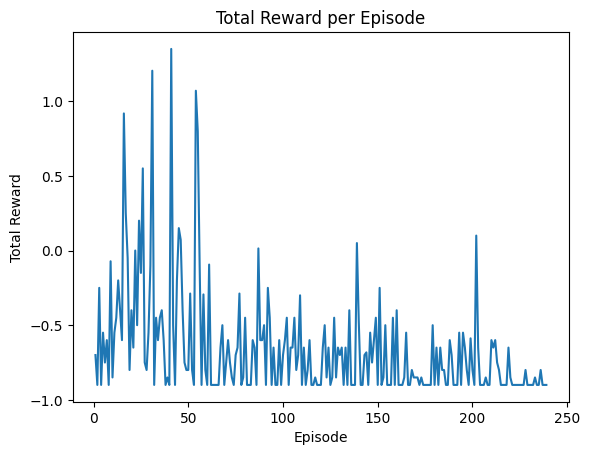

In [ ]:
agent.plot_rewards()

In [ ]:
agent.play_game()

In [ ]:
agent.play_game()

In [ ]:
agent.play_game()